In [24]:
import pandas as pd
# import sklearn as sk
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn import datasets
from statistics import mean
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Generate Data

I need both X1, X2, X3 as data and a repose Y1, Y2, Y3 value


In [25]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
np.random.seed(42)

# Number of rows in the DataFrame
num_rows = 1000000

# Generate data
columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']
covariates = ['1', '-2', '0.22', '1.2', '-1.2', '6', '1.2', '1.1']
df = pd.DataFrame(columns=columns)

all_data= []

for i in range(num_rows):
    np.random.seed(42+i)
    p1 = np.random.normal(loc=0, scale=1)
    p2 = np.random.normal(loc=-2, scale=0.2)
    p3 = np.random.normal(loc=10, scale=2)
    p4 = np.random.poisson(lam=7)
    p5 = np.random.poisson(lam=2)
    p6 = np.random.gamma(shape=2, scale=1)
    p7 = np.random.gamma(shape=3, scale=1)
    values = [p1, p2, p3, p4, p5, p6, p7]
    # Generate Xi values
    all_data.append(dict(zip(columns,values)))


# Display the DataFrame
df = pd.DataFrame(all_data, columns=columns)

# Finding Y values 

We will split data in the following ways:

1) [123] vs [4]

2) [13] vs [2]

3) [1] vs [3]

We will do a logistic regression with each of them. I will use 3 different sets of covariates to do this. 1) will use covariates_1, 2) will use covariates_2, 3) will use covariates_3

In [6]:
# Generate Y value 
covariates_1 = ['-10', '-1', '0.22', '1.2', '-.2', '6', '1.2', '-9']
covariates_2 = ['5', '2', '8', '1.9', '-1.2', '0.89', '1.2', '-4.2']
covariates_3 = ['-1', '0.2', '-1', '-1.2', '-0.22', '3', '-2', '2.2']   
bern_1_prob = []
bern_2_prob = []
bern_3_prob = []
for i in df.iterrows():
    mutliplyer = [1.0] + i[1].tolist()
    # mutliplyer[0] = 1.0
    result_array = np.array(covariates_1, dtype=float) * np.array(mutliplyer)
    bern_1_prob.append(sigmoid(sum(result_array)))

    result_array = np.array(covariates_2, dtype=float) * np.array(mutliplyer)
    bern_2_prob.append(sigmoid(sum(result_array)))

    result_array = np.array(covariates_3, dtype=float) * np.array(mutliplyer)
    bern_3_prob.append(sigmoid(sum(result_array)))


In [7]:
# Caclulate the Y value
Y = []
for row in df.iterrows():
    bern_1 = np.random.binomial(1, bern_1_prob[row[0]])
    if bern_1 == 1:
        Y.append(4)
        #type 4
    elif np.random.binomial(1, bern_2_prob[row[0]]) == 1:
        Y.append(2)
        #type 2
    elif np.random.binomial(1, bern_3_prob[row[0]]) == 1:
        Y.append(3)
        #type 3
    else:
        Y.append(1)
        #type 1
df['Y'] = Y


In [42]:
new = df.drop(['123_4'], axis=1)
new.to_csv('model_data1.csv', columns=['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'Y'])

# Use multinomial regression from scikit 
Now estimate the covariates from above 

In [8]:
df_x = df.drop('Y', axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_x, Y, test_size=0.2, random_state=42)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

In [9]:
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred, target_names=['1','2','3','4']))

Accuracy: 0.90
              precision    recall  f1-score   support

           1       0.90      0.93      0.91     96117
           2       0.78      0.65      0.71     11895
           3       0.89      0.86      0.87     42442
           4       0.92      0.93      0.93     49546

    accuracy                           0.90    200000
   macro avg       0.87      0.84      0.85    200000
weighted avg       0.90      0.90      0.90    200000



In [10]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

TypeError: Invalid shape (4, 2, 2) for image data

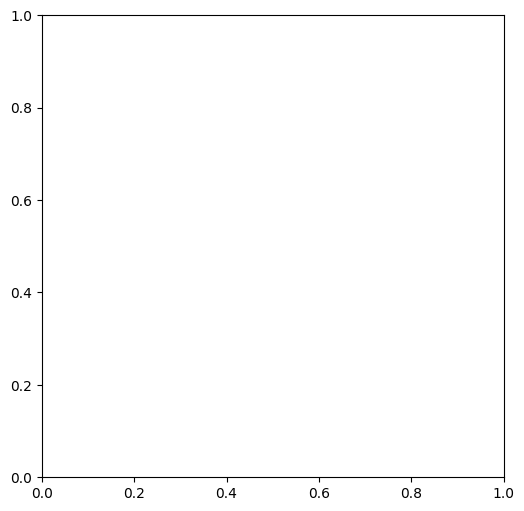

In [13]:
mcm = multilabel_confusion_matrix(y_test, y_pred, labels=['1','2','3','4'])
plot_confusion_matrix(mcm, target_names = ['1','2','3','4'])

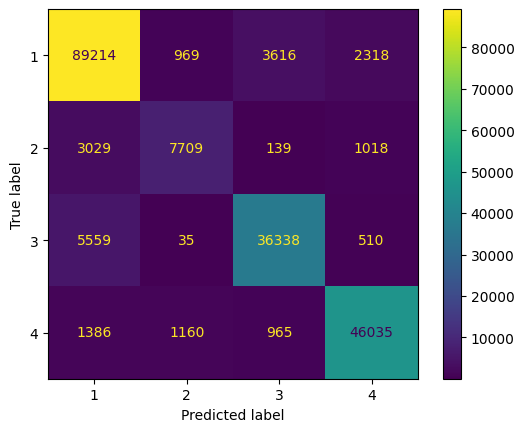

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [77]:
## Do not run
for i, class_name in enumerate(['1','2','3','4']):
    print(f"\nClass: {class_name}")
    print(f"Intercept: {model.intercept_[i]:.4f}")
    for feature, coef in zip(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7'], model.coef_[i]):
        print(f"{feature}: {coef:.4f}")
covariates_1 = ['-10', '-1', '0.22', '1.2', '-.2', '6', '1.2', '-9']
covariates_2 = ['5', '2', '8', '1.9', '-1.2', '0.89', '1.2', '-4.2']
covariates_3 = ['-1', '0.2', '-1', '-1.2', '-0.22', '3', '-2', '2.2']


Class: 1
Intercept: 1.8882
p1: -0.1892
p2: -1.5898
p3: -0.4974
p4: 0.3569
p5: -2.7909
p6: -0.1649
p7: 3.1033


Class: 2
Intercept: 4.9021
p1: 1.1658
p2: 3.6225
p3: 0.7150
p4: -0.4376
p5: -2.0092
p6: 0.5377
p7: 0.4535


Class: 3
Intercept: 1.2960
p1: -0.0281
p2: -2.2165
p3: -1.4283
p4: 0.1836
p5: -0.5761
p6: -1.7250
p7: 4.8635


Class: 4
Intercept: -8.0862
p1: -0.9485
p2: 0.1839
p3: 1.2107
p4: -0.1029
p5: 5.3762
p6: 1.3522
p7: -8.4203



# Use New Method 

Run multiple logistic regressions manually. FIrst time is run this one: 

1) [123] vs [4]

2) [13] vs [2]

3) [1] vs [3]


In [17]:
df['123_4'] = df['Y'].apply(lambda x: 1 if x == 4 else 0)
df['13_2'] = df['Y'].apply(lambda x: 1 if x == 2 else 0)
df['1_3'] = df['Y'].apply(lambda x: 1 if x == 3 else 0)

In [18]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df, df['Y'], test_size=0.2, random_state=42)

In [19]:
# Fit our models
model_1 = LogisticRegression(solver='lbfgs', max_iter=1000)
model_2 = LogisticRegression(solver='lbfgs', max_iter=1000)
model_3 = LogisticRegression(solver='lbfgs', max_iter=1000)

#model 1
x1_data = X1_train
Y = x1_data['123_4']
model_1.fit(x1_data.drop(['Y','123_4', '13_2', '1_3'], axis=1), Y)

#model 2
x2_data = x1_data[x1_data['123_4']==0]
Y = x2_data['13_2']
model_2.fit(x2_data.drop(['Y','123_4', '13_2', '1_3'], axis=1),Y)

#model 3
x3_data = x2_data[x2_data['13_2']==0]
Y = x3_data['1_3']
model_3.fit(x3_data.drop(['Y','123_4', '13_2', '1_3'], axis=1),Y)


LogisticRegression(max_iter=1000)

In [20]:
#test our model
X1_test['key'] = X1_test.index
#model 1
y_pred = model_1.predict(X1_test.drop(['Y','123_4', '13_2', '1_3', 'key'], axis=1))
X1_test['1_pred'] = y_pred

#model 2
x2_data = X1_test[X1_test['1_pred'] == 0]
y_pred = model_2.predict(x2_data.drop(['Y','123_4', '13_2', '1_3', '1_pred', 'key'], axis=1))
x2_data['2_pred'] = y_pred

#model 3
x3_data = x2_data[x2_data['2_pred'] == 0]
y_pred = model_3.predict(x3_data.drop(['Y','123_4', '13_2', '1_3', '1_pred', '2_pred', 'key'], axis=1))
x3_data['3_pred'] = y_pred


C:\Users\maxdi\AppData\Local\Temp\ipykernel_22884\4176571644.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x2_data['2_pred'] = y_pred
C:\Users\maxdi\AppData\Local\Temp\ipykernel_22884\4176571644.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x3_data['3_pred'] = y_pred


In [21]:
slice_X1_test = X1_test[['key', '1_pred']]
slice_x2_data = x2_data[['key', '2_pred']]
slice_x3_data = x3_data[['key', '3_pred']]

merged_df = slice_X1_test.merge(slice_x2_data, on='key', how='left').merge(slice_x3_data, on='key', how='left')

In [22]:
merged_df['Y'] = np.where((merged_df['1_pred'] == 1), 4,
                   np.where((merged_df['2_pred'] == 1), 2,
                            np.where( (merged_df['3_pred'] == 1), 3, 1)))

In [67]:
df_tiny = df.head(1000)
df_tiny.drop(['123_4', '13_2', '1_3'],axis=1).to_csv("tiny_one.csv")

In [66]:
df.head(30)

,p1,p2,p3,p4,p5,p6,p7,Y,123_4,13_2,1_3
0,0.496714,-2.027653,11.295377,4,1,4.507450,1.971140,2,0,1,0
1,0.257400,-2.181696,9.242994,6,2,1.067081,1.972040,1,0,0,0
2,-0.750615,-1.736729,12.492280,8,4,0.334719,2.462191,4,1,0,0
3,0.026375,-1.947936,9.209709,4,5,1.416584,0.707701,4,1,0,0
4,0.584876,-1.753761,11.643801,7,3,0.833143,2.011525,4,1,0,0
5,-0.848009,-1.738819,11.848416,5,0,2.637679,0.976809,2,0,1,0
6,-0.993631,-2.212680,8.723848,6,3,3.447151,2.112449,4,1,0,0
7,-1.043159,-2.164171,11.330292,11,1,5.300693,3.126612,1,0,0,0
8,-1.560352,-2.006196,8.758143,8,5,0.400774,4.626778,3,0,0,1
9,-0.290503,-1.977574,12.501590,6,2,0.454799,2.468008,1,0,0,0


0.903145
              precision    recall  f1-score   support

           1       0.90      0.93      0.92     96117
           2       0.78      0.71      0.74     11895
           3       0.88      0.87      0.88     42442
           4       0.94      0.94      0.94     49546

    accuracy                           0.90    200000
   macro avg       0.88      0.86      0.87    200000
weighted avg       0.90      0.90      0.90    200000



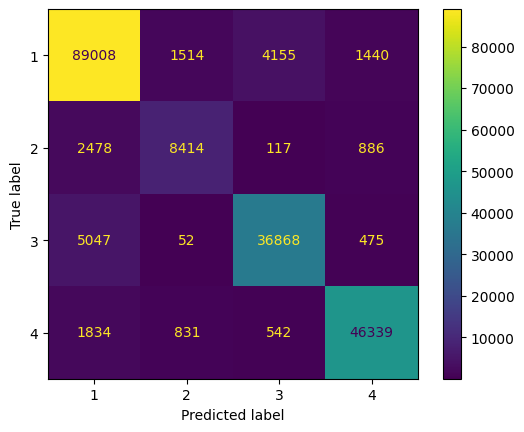

In [23]:
print(accuracy_score(y1_test.to_list(), merged_df[['Y']]))
print(classification_report(y1_test.to_list(), merged_df[['Y']], target_names=['1','2','3','4']))
ConfusionMatrixDisplay.from_predictions(y1_test.to_list(), merged_df[['Y']])

In [31]:
# Check how our real covariates match up with our models 
covariates_1 = ['-10', '-1', '0.22', '1.2', '-.2', '6', '1.2', '-9']
covariates_2 = ['5', '2', '8', '1.9', '-1.2', '0.89', '1.2', '-4.2']
covariates_3 = ['-1', '0.2', '-1', '-1.2', '-0.22', '3', '-2', '2.2']

cov_1_dict = dict(zip(['X', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7'], covariates_1))
cov_2_dict = dict(zip(['X', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7'], covariates_2))
cov_3_dict = dict(zip(['X', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7'], covariates_3))

print(f"\nRegression 1")
print(f"Intercept: {model_1.intercept_[0]:.4f} vs real: {cov_1_dict['X']}")
for feature, coef in zip(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7'], model_1.coef_[0]):
        print(f"{feature}: {coef:.4f} vs real {cov_1_dict[feature]}")

print(f"\nRegression 2")
print(f"Intercept: {model_2.intercept_[0]:.4f} vs real: {cov_2_dict['X']}")
for feature, coef in zip(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7'], model_2.coef_[0]):
        print(f"{feature}: {coef:.4f} vs real {cov_2_dict[feature]}")

print(f"\nRegression 3")
print(f"Intercept: {model_3.intercept_[0]:.4f} vs real: {cov_3_dict['X']}")
for feature, coef in zip(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7'], model_3.coef_[0]):
        print(f"{feature}: {coef:.4f} vs real {cov_3_dict[feature]}")



Regression 1
Intercept: -10.2102 vs real: -10
p1: -1.0060 vs real -1
p2: 0.1772 vs real 0.22
p3: 1.2133 vs real 1.2
p4: -0.2021 vs real -.2
p5: 6.0475 vs real 6
p6: 1.2046 vs real 1.2
p7: -9.0635 vs real -9

Regression 2
Intercept: 4.9502 vs real: 5
p1: 1.9956 vs real 2
p2: 7.9972 vs real 8
p3: 1.9001 vs real 1.9
p4: -1.1957 vs real -1.2
p5: 0.8761 vs real 0.89
p6: 1.1897 vs real 1.2
p7: -4.1723 vs real -4.2

Regression 3
Intercept: -1.0216 vs real: -1
p1: 0.2040 vs real 0.2
p2: -1.0345 vs real -1
p3: -1.2042 vs real -1.2
p4: -0.2233 vs real -0.22
p5: 3.0063 vs real 3
p6: -2.0018 vs real -2
p7: 2.2000 vs real 2.2


1 vs 2 3 4
1 4 vs 2 3
3 4 vs 1 2
3 vs 1 2 4
1 2 4 vs 3
1 2 3 vs 4
4 vs 1 2 3
2 3 4 vs 1
1 3 4 vs 2
2 4 vs 1 3
2 3 vs 1 4
2 vs 1 3 4
1 2 vs 3 4
1 3 vs 2 4
